In [1]:
from __future__ import print_function

### TensorFlow Arhictecture

![A](image6.png)

### Load Libraries

In [2]:
import os
import sys
sys.path.append('../')

import tensorflow as tf
from models.cnn_model import CNN_Model
from data.data_pipeline import get_input_fn
from hparams.yparams import YParams
from parse_tensorboard_tfevents import get_training_history

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('demo_style.mplstyle')

### Create model_fn

In [3]:
def model_fn(features, labels, params, mode):
    """ Build graph and return EstimatorSpec """

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    model = CNN_Model(params, input_x=features, is_training=is_training)

    if mode is not tf.estimator.ModeKeys.PREDICT:
        # loss and optimizer are not needed for inference
        model.define_loss(labels)
        model.define_optimizer()

    with tf.variable_scope('eval_metrics') as _:
        eval_metrics = {}
        eval_metrics['acc'] = tf.metrics.accuracy(labels=labels, predictions=model.predictions)

    return tf.estimator.EstimatorSpec(predictions=model.predictions,
                                      loss=model.loss,
                                      train_op=model.optimizer,
                                      eval_metric_ops=eval_metrics,
                                      mode=mode)

### load parameters

In [4]:
configurations_path = '../hparams/cnn.yaml'
experiment = 'demo_single_node'
params = YParams(configurations_path, experiment)

train_dataset_size 128000
valid_dataset_size 64000
train_data_files ../data/train.h5
valid_data_files ../data/valid.h5
epochs 16
experiment_dir ../logs/demo_single_node
data_format channels_last
input_shape ['None', 64, 64, 1]
conv_filters [16, 32, 64]
conv_args CommentedMap([('kernel_size', 3), ('strides', 1), ('padding', 'same'), ('activation', 'relu')])
maxpool_args CommentedMap([('pool_size', 2), ('strides', 2)])
conv_dropout_rate 0.2
fc_hidden_units [128]
fc_dropout_rates [0.2]
fc_activation relu
learning_rate 0.001
batchsize 128


### Create data pipelines

In [5]:
# create training data input pipeline
train_input_fn, train_init_hook = get_input_fn(params.train_data_files,
                                               dataset_size=params.train_dataset_size,
                                               batchsize=params.batchsize,
                                               epochs=params.epochs,
                                               variable_scope='train_data_pipeline')

max_steps = (params.train_dataset_size//params.batchsize)*params.epochs
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn,
                                    hooks=[train_init_hook],
                                    max_steps=max_steps)

# create validation data input pipeline
valid_input_fn, valid_init_hook = get_input_fn(params.valid_data_files,
                                               dataset_size=params.valid_dataset_size,
                                               batchsize=params.batchsize,
                                               epochs=params.epochs,
                                               variable_scope='valid_data_pipeline')

eval_spec = tf.estimator.EvalSpec(input_fn=valid_input_fn,
                                  hooks=[valid_init_hook],
                                  start_delay_secs=10,
                                  throttle_secs=15)

### Build estimator

In [6]:
config = tf.estimator.RunConfig(save_checkpoints_secs=20) # too frequent, just for demo

In [7]:
estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=params.experiment_dir,
                                   config=config,
                                   params=params)

INFO:tensorflow:Using config: {'_service': None, '_train_distribute': None, '_model_dir': '../logs/demo_single_node', '_save_checkpoints_secs': 20, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_log_step_count_steps': 100, '_master': '', '_task_type': 'worker', '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_device_fn': None, '_evaluation_master': '', '_session_config': None, '_num_worker_replicas': 1, '_task_id': 0, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbd4c77bf98>}


### Train Model

In [8]:
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 20.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logs/demo_single_node/model.ckpt.
INFO:tensorflow:loss = 0.694467, step = 0
INFO:tensorflow:global_step/sec: 73.607
INFO:tensorflow:loss = 0.296301, step = 100 (1.360 sec)
INFO:tensorflow:global_step/sec: 93.9596
INFO:tensorflow:loss = 0.178003, step = 200 (1.064 sec)
INFO:tensorflow:global_step/sec: 85.0371
INFO:tensorflow:loss = 0.168707, step = 300 (1.177 sec)
INFO:tensorflow:global_step/sec: 86.7084
INFO:tensorflo

INFO:tensorflow:Saving dict for global step 4706: acc = 0.00015625, global_step = 4706, loss = 0.0326997
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4706: ../logs/demo_single_node/model.ckpt-4706
INFO:tensorflow:global_step/sec: 32.7892
INFO:tensorflow:loss = 0.0359267, step = 4800 (3.050 sec)
INFO:tensorflow:global_step/sec: 88.1838
INFO:tensorflow:loss = 0.0418989, step = 4900 (1.134 sec)
INFO:tensorflow:global_step/sec: 88.5119
INFO:tensorflow:loss = 0.0333821, step = 5000 (1.130 sec)
INFO:tensorflow:global_step/sec: 89.7048
INFO:tensorflow:loss = 0.0627323, step = 5100 (1.114 sec)
INFO:tensorflow:global_step/sec: 86.3568
INFO:tensorflow:loss = 0.0270306, step = 5200 (1.158 sec)
INFO:tensorflow:global_step/sec: 86.6493
INFO:tensorflow:loss = 0.0231718, step = 5300 (1.155 sec)
INFO:tensorflow:global_step/sec: 89.3776
INFO:tensorflow:loss = 0.0570739, step = 5400 (1.119 sec)
INFO:tensorflow:global_step/sec: 88.799
INFO:tensorflow:loss = 0.0247868, step = 5500 (1.1

INFO:tensorflow:global_step/sec: 86.5808
INFO:tensorflow:loss = 0.0174032, step = 9700 (1.155 sec)
INFO:tensorflow:global_step/sec: 88.2412
INFO:tensorflow:loss = 0.0189294, step = 9800 (1.134 sec)
INFO:tensorflow:global_step/sec: 86.4083
INFO:tensorflow:loss = 0.00646236, step = 9900 (1.157 sec)
INFO:tensorflow:global_step/sec: 86.0443
INFO:tensorflow:loss = 0.0283938, step = 10000 (1.162 sec)
INFO:tensorflow:global_step/sec: 93.6671
INFO:tensorflow:loss = 0.00607075, step = 10100 (1.068 sec)
INFO:tensorflow:global_step/sec: 86.6257
INFO:tensorflow:loss = 0.00949119, step = 10200 (1.154 sec)
INFO:tensorflow:global_step/sec: 87.045
INFO:tensorflow:loss = 0.0264167, step = 10300 (1.150 sec)
INFO:tensorflow:global_step/sec: 88.1909
INFO:tensorflow:loss = 0.0488369, step = 10400 (1.133 sec)
INFO:tensorflow:global_step/sec: 85.0247
INFO:tensorflow:loss = 0.00907548, step = 10500 (1.176 sec)
INFO:tensorflow:global_step/sec: 84.0088
INFO:tensorflow:loss = 0.0215473, step = 10600 (1.190 sec)


INFO:tensorflow:loss = 0.0403146, step = 14700 (1.151 sec)
INFO:tensorflow:global_step/sec: 90.8093
INFO:tensorflow:loss = 0.0388443, step = 14800 (1.101 sec)
INFO:tensorflow:global_step/sec: 85.1776
INFO:tensorflow:loss = 0.0342697, step = 14900 (1.174 sec)
INFO:tensorflow:global_step/sec: 86.3676
INFO:tensorflow:loss = 0.0160862, step = 15000 (1.158 sec)
INFO:tensorflow:global_step/sec: 86.7555
INFO:tensorflow:loss = 0.0156461, step = 15100 (1.153 sec)
INFO:tensorflow:global_step/sec: 87.8156
INFO:tensorflow:loss = 0.00310411, step = 15200 (1.139 sec)
INFO:tensorflow:global_step/sec: 90.732
INFO:tensorflow:loss = 0.00293873, step = 15300 (1.102 sec)
INFO:tensorflow:global_step/sec: 86.8537
INFO:tensorflow:loss = 0.0149757, step = 15400 (1.151 sec)
INFO:tensorflow:global_step/sec: 87.6913
INFO:tensorflow:loss = 0.0123167, step = 15500 (1.140 sec)
INFO:tensorflow:global_step/sec: 89.761
INFO:tensorflow:loss = 0.0418978, step = 15600 (1.114 sec)
INFO:tensorflow:Saving checkpoints for 15

({'acc': 0.1153125, 'global_step': 16000, 'loss': 0.040145278}, [])

### Examine learning curves

In [9]:
train_hist, valid_hist = get_training_history(model_dir=params.experiment_dir)

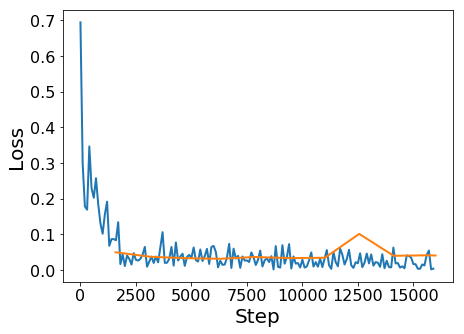

In [10]:
plt.plot(train_hist['loss']['steps'], train_hist['loss']['values'], label='train');
plt.plot(valid_hist['loss']['steps'], valid_hist['loss']['values'], label='valid');
plt.ylabel('Loss');
plt.xlabel('Step');

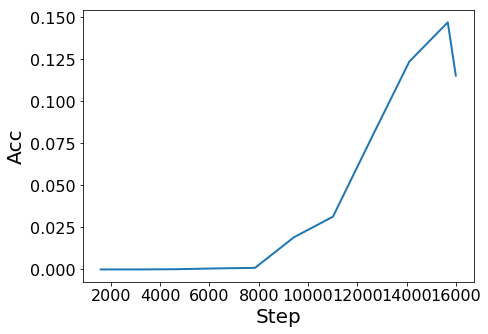

In [11]:
plt.plot(valid_hist['acc']['steps'], valid_hist['acc']['values'], label='valid');
plt.ylabel('Acc');
plt.xlabel('Step');

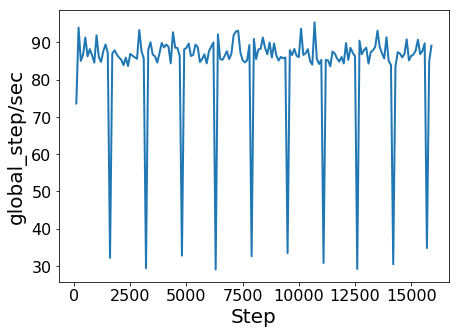

In [12]:
plt.plot(train_hist['global_step/sec']['steps'], train_hist['global_step/sec']['values']);
plt.ylabel('global_step/sec');
plt.xlabel('Step');